# Reinforcement Learning for Navigation Network Study

In [1]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import MultiAgentVecEnv

from mlagents_envs.exception import UnityTimeOutException, UnityWorkerInUseException
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

import torch as th

import os, yaml
import random
import time
import datetime
import numpy as np
import torch as th
from torch import nn

from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToMultiGymWrapper 
import wandb
from rlnav.logging import WANDBMonitor, test_model
from rlnav.schedules import linear_schedule
from pathlib import Path

In [2]:
from torchsummary import summary

In [3]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

## The Incoming Data

![The Point the data is gathered](tmp/Observation.png "The observation")

In [5]:
observations = np.load('observation505_fixed.npy')
print("Loaded shape:", observations.shape)
observations = observations.squeeze()

vector_size    = 19 
whisker_size   = 26 + 6 # 6 represents the rotation observation which is included in depth_map component but can be ignored.
depth_size     = 55 - 6
occupancy_size = 405

vector_end    = vector_size
whisker_end   = vector_end  + whisker_size
depth_end     = whisker_end + depth_size
occupancy_end = depth_end   + occupancy_size

Loaded shape: (10000, 1, 505)


In [6]:
vec_obs       = observations[:, 0:vector_end]
whisker_obs   = observations[:, vector_end :whisker_end]
depth_obs     = observations[:, whisker_end:depth_end]
occupancy_obs = observations[:, depth_end  :occupancy_end]

assert vec_obs.shape[1]+ whisker_obs.shape[1]+ depth_obs.shape[1] + occupancy_obs.shape[1] == 505 
print(vec_obs.shape[1]+ whisker_obs.shape[1]+ depth_obs.shape[1] + occupancy_obs.shape[1])

505


## Depthmask

![The Point the data is gathered](tmp/Depthmask.png "The observation")

#### The ground is not shown. Raycasts ignore the collider if they are spawned from the inside of it.

In [7]:
depth_obs.shape

(10000, 49)

In [8]:
print(depth_obs[0])

[0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997]


In [9]:
depth_obs.shape
depth_obs_2d = depth_obs.reshape(-1, 7, 7)  ### Occupancy Grid
depth_obs_2d.shape

(10000, 7, 7)

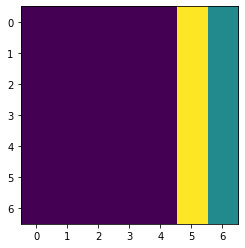

In [10]:
imshow(depth_obs_2d[100])

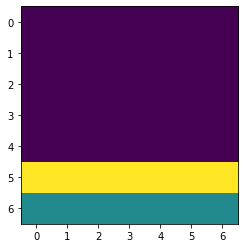

In [11]:
imshow(depth_obs_2d[100].T)

## Occupancy Grid

![The Point the data is gathered](tmp/Occupancy.png "The observation")

## (9, 5, 9) - (x,y,z) box size

In [12]:
occupancy_obs.shape
occupancy_obs_3d = occupancy_obs.reshape(-1, 9, 5, 9)
occupancy_obs_3d_plt = np.swapaxes(occupancy_obs_3d, -1, -2)

In [13]:
idx = random.randint(0,512)
print(idx)

74


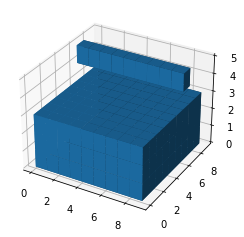

In [14]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(occupancy_obs_3d_plt[idx-1])

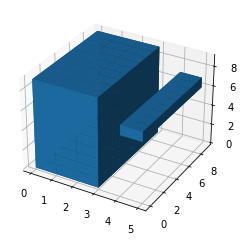

In [15]:
occupancy_obs.shape
occupancy_obs_3d = occupancy_obs.reshape(-1, 9, 5, 9)
occupancy_obs_3d_swapped_plt = np.swapaxes(occupancy_obs_3d, -2, -3)

ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(occupancy_obs_3d_swapped_plt[idx-1])

### Preprocessing input

In [16]:
batch_size = 512
input_tensor = th.tensor(observations[:batch_size]).cuda()
action_dim = 3

depthmap_side_size = 7
occupancy_grid_shape = (9,5,9) 

is_critic = False # When the network is the critic the actions are appended to the end of the input. policies.py 847

In [17]:
depth_obs.shape
vector_end

19

In [18]:
# This is done at every forward.
if is_critic:
    original_vector = input_tensor[:, :whisker_end]
    actions_in_critic = input_tensor[:, -action_dim:]
    vector_obs = th.cat((original_vector, actions_in_critic),dim=1)
else:
    vector_obs = input_tensor[:, :whisker_end].cuda()

depth_obs     = input_tensor[:, whisker_end: depth_end]
occupancy_obs = input_tensor[:, depth_end: occupancy_end]

depth_obs2d = depth_obs.reshape(-1, 1, depthmap_side_size, depthmap_side_size)
occupancy_obs3d = occupancy_obs.reshape(-1, 1, *occupancy_grid_shape)

In [19]:
assert depth_obs.shape[1] == 49
assert occupancy_obs.shape[1] == 405


In [20]:
print(vector_obs.shape)
print(depth_obs2d.shape)
print(occupancy_obs3d.shape)

assert 505 == vector_obs.shape[-1] + \
              depth_obs2d.shape[-2] * depth_obs2d.shape[-1] + \
              occupancy_obs3d.shape[-3] * occupancy_obs3d.shape[-2] * occupancy_obs3d.shape[-1]

torch.Size([512, 51])
torch.Size([512, 1, 7, 7])
torch.Size([512, 1, 9, 5, 9])


### Depthmap Layers

In [21]:
depth_obs2d.shape

torch.Size([512, 1, 7, 7])

In [22]:
class MyGlobal2DMaxPoolLayer(nn.Module): #Is this the correct name?
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return th.mean(x, dim =(-2,-1))

In [23]:
def create_depthmap_layers(): 
    conv2d_size = 64
    depthmap_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=conv2d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        nn.Conv2d(conv2d_size,   out_channels=conv2d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        MyGlobal2DMaxPoolLayer(),
    ) 
    return depthmap_layers

depthmap_layers = create_depthmap_layers()
depthmap_layers.cuda()

depthmap_layers_output_shape = depthmap_layers(depth_obs2d).shape[-1]
summary(depthmap_layers, depth_obs2d.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 9, 9]             640
              ReLU-2             [-1, 64, 9, 9]               0
            Conv2d-3           [-1, 64, 11, 11]          36,928
              ReLU-4           [-1, 64, 11, 11]               0
MyGlobal2DMaxPoolLayer-5                   [-1, 64]               0
Total params: 37,568
Trainable params: 37,568
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.14
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


### Occupancy Layers

In [24]:
class MyGlobal3DMaxPoolLayer(nn.Module): #Is this the correct name?
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return th.mean(x, dim=(-3, -2,-1))

In [25]:
def create_occupancy_layers():
    conv3d_size = 32
    occupancy_layers = nn.Sequential(
        nn.Conv3d(in_channels=1, out_channels=conv3d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        nn.Conv3d(conv3d_size,   out_channels=conv3d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        MyGlobal3DMaxPoolLayer()
    )
    return occupancy_layers

occupancy_layers = create_occupancy_layers()
occupancy_layers.cuda()
occupancy_layers_output_shape = occupancy_layers(occupancy_obs3d.cuda()).shape[-1]

summary(occupancy_layers, occupancy_obs3d.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 32, 11, 7, 11]             896
              ReLU-2        [-1, 32, 11, 7, 11]               0
            Conv3d-3        [-1, 32, 13, 9, 13]          27,680
              ReLU-4        [-1, 32, 13, 9, 13]               0
MyGlobal3DMaxPoolLayer-5                   [-1, 32]               0
Total params: 28,576
Trainable params: 28,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.16
Params size (MB): 0.11
Estimated Total Size (MB): 1.27
----------------------------------------------------------------


In [26]:
def create_occupancy2D_layers():
    conv3d_size = 64
    occupancy_layers = nn.Sequential(
        nn.Conv2d(in_channels=5, out_channels=conv3d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        nn.Conv2d(conv3d_size,   out_channels=conv3d_size, kernel_size=3, padding=2, stride=1), nn.ReLU(),
        MyGlobal2DMaxPoolLayer()
    )
    return occupancy_layers

occupancy_layers = create_occupancy2D_layers()
occupancy_layers.cuda()

occupancy_obs2d = np.squeeze(np.swapaxes(occupancy_obs3d, -2, -3))
occupancy_layers_output_shape = occupancy_layers(occupancy_obs2d.cuda()).shape[-1]

summary(occupancy_layers, occupancy_obs2d.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 11, 11]           2,944
              ReLU-2           [-1, 64, 11, 11]               0
            Conv2d-3           [-1, 64, 13, 13]          36,928
              ReLU-4           [-1, 64, 13, 13]               0
MyGlobal2DMaxPoolLayer-5                   [-1, 64]               0
Total params: 39,872
Trainable params: 39,872
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 0.15
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


### Vector Layers

In [27]:
def create_vector_layers():
    hidden_dim = 512
    vector_layers = nn.Sequential(
        nn.Linear(vector_obs.shape[-1], hidden_dim), nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim), 
    )
    return vector_layers

vector_layers = create_vector_layers()
vector_layers.cuda()

Sequential(
  (0): Linear(in_features=51, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
)

### Combine Layers

In [28]:
hidden_dim = 512
combo_model = nn.Sequential(
    nn.Linear(hidden_dim + occupancy_layers_output_shape + depthmap_layers_output_shape, hidden_dim), nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
)
combo_model.cuda()

Sequential(
  (0): Linear(in_features=640, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
)

In [29]:
depth_output     = th.squeeze(depthmap_layers(depth_obs2d.cuda()))
occupancy_output = th.squeeze(occupancy_layers(occupancy_obs3d.cuda()))
vector_output    = th.squeeze(vector_layers(vector_obs.cuda()))

# Get the combination and pass it through the last linear layers.
combined_input = th.cat((vector_output, occupancy_output, depth_output), dim=1)
output = combo_model(combined_input)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 5, 3, 3], but got 5-dimensional input of size [512, 1, 9, 5, 9] instead

### Full Network

In [ ]:
class RLCustomNetwork(nn.Module):
    def __init__(self):
        super(RLCustomNetwork, self).__init__()
        self.create_model()
    
    def create_model(self):
        conv2d_size = 32
        conv3d_size = 32
        hidden_dim = 512
        
        self.depthmap_layers = create_depthmap_layers().cuda()
        
        self.occupancy_layers= create_occupancy_layers().cuda()
        
        self.vector_layers = create_vector_layers().cuda()
        
        self.combo_model = nn.Sequential(
            nn.Linear(hidden_dim + occupancy_layers_output_shape + depthmap_layers_output_shape, hidden_dim), nn.ReLU(),
        ).cuda()
        
       
    def forward(self, input_tensor):
        if is_critic:
            original_vector = input_tensor[:, :whisker_end]
            actions_in_critic = input_tensor[:, -action_dim:]
            vector_obs = th.cat((original_vector, actions_in_critic),dim=1).cuda()
        else:
            vector_obs = input_tensor[:, :whisker_end].cuda() # Vectorend includes whiskers

        depth_obs     = input_tensor[:, whisker_end: depth_end]
        occupancy_obs = input_tensor[:, depth_end: occupancy_end]

        depth_obs2d = depth_obs.reshape(-1, 1, depthmap_side_size, depthmap_side_size) # 1 is the filter size
        occupancy_obs3d = occupancy_obs.reshape(-1, 1, *occupancy_grid_shape)
        
        depth_output     = th.squeeze(self.depthmap_layers(depth_obs.reshape(-1, 1, depthmap_side_size, depthmap_side_size)))
        occupancy_output = th.squeeze(self.occupancy_layers(occupancy_obs.reshape(-1, 1, *occupancy_grid_shape)))
        vector_output    = self.vector_layers(vector_obs)
        
        combined_input = th.cat((vector_output, occupancy_output, depth_output), dim=1)
        output = self.combo_model(combined_input)
        
        return output

In [ ]:
net = RLCustomNetwork()
net(input_tensor).shape

In [ ]:
summary(net, input_tensor.shape[1:])

# PROFILING

In [ ]:
# Default network trace profiler: https://wandb.ai/batu/Urban/artifacts/profile/trace-z1crfyl9/dea233bef8b2339f4b0e/files/trace.pt.trace.json
# Custom network: https://wandb.ai/batu/Urban/artifacts/profile/trace-1mxyn7xs/1c4f8c37348d7efb23d8/files/trace.pt.trace.json

In [ ]:
import pstats
from pstats import SortKey

In [ ]:
# #   net_arch: 
# #     pi: 
# #       - 512
# #       - 512
# #     qf:
# #       - 1024
# #       - 1024
# #       - 1024
# # trainable params: 11m
# # mlp_mini 

# mlp = pstats.Stats('profiling/mlp.file')
# mlp.sort_stats("tottime").print_stats(10)

In [ ]:
# trainable params: 1176679
# Custom built network 

mlp = pstats.Stats('profiling/mlp.file')
mlp.sort_stats("tottime").print_stats(50)

# MLP

In [ ]:
 296.3 - 205 

In [ ]:
572 - 221

In [ ]:
25000 / 64 * 256

In [ ]:
# trainable params: 6076679
# Custom built network 

custom_default = pstats.Stats('profiling/custom_default.file')
custom_default.sort_stats("tottime").print_stats(10)

# CONV2d / CONV3d

In [39]:
# trainable params: 6076679
# Custom built network with slicing done converted to and back from numpy

custom_numpyslice = pstats.Stats('profiling/custom_numpyslice.file')
custom_numpyslice.sort_stats("tottime").print_stats(10)

Thu Aug 26 12:13:01 2021    profiling/custom_numpyslice.file

         22954041 function calls (21033095 primitive calls) in 619.846 seconds

   Ordered by: internal time
   List reduced from 12753 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      967  225.374    0.233  225.374    0.233 {built-in method _winapi.WaitForMultipleObjects}
    28230  103.479    0.004  103.479    0.004 {method 'cpu' of 'torch._C._TensorBase' objects}
    17589   82.290    0.005   82.291    0.005 {method 'to' of 'torch._C._TensorBase' objects}
     9984   36.352    0.004   36.352    0.004 {method 'run_backward' of 'torch._C._EngineBase' objects}
    10803   15.429    0.001   16.821    0.002 C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\torch\distributions\distribution.py:34(__init__)
    13312   14.546    0.001   14.546    0.001 {method 'item' of 'torch._C._TensorBase' objects}
    82281   12.137    0.000   12.137    0.000 {method 'cuda' of 't

In [45]:
# trainable params: 3610087
# Custom built network  with Adam

custom_new = pstats.Stats('profiling/custom_new.file')
custom_new.sort_stats("tottime").print_stats(10)

Thu Aug 26 13:55:55 2021    profiling/custom_new.file

         23680886 function calls (21840620 primitive calls) in 1379.732 seconds

   Ordered by: internal time
   List reduced from 12757 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    13312  545.294    0.041  545.294    0.041 {method 'item' of 'torch._C._TensorBase' objects}
    17609  289.391    0.016  289.392    0.016 {method 'to' of 'torch._C._TensorBase' objects}
      967  234.159    0.242  234.159    0.242 {built-in method _winapi.WaitForMultipleObjects}
    10803  123.615    0.011  125.501    0.012 C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\torch\distributions\distribution.py:34(__init__)
     9984   46.179    0.005   46.179    0.005 {method 'run_backward' of 'torch._C._EngineBase' objects}
   109824   11.302    0.000   13.715    0.000 c:\users\batua\desktop\rlnav\rlagency\stable-baselines3\stable_baselines3\common\utils.py:365(zip_strict)
   117167   11.

In [55]:
# trainable params: 6076679
# no gpu

only_cpu = pstats.Stats('profiling/only_cpu.file')
only_cpu.sort_stats("tottime").print_stats(10)

Thu Aug 26 15:50:31 2021    profiling/only_cpu.file

         11153697 function calls (10382652 primitive calls) in 6599.827 seconds

   Ordered by: internal time
   List reduced from 12223 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4005 3995.416    0.998 3995.416    0.998 {method 'run_backward' of 'torch._C._EngineBase' objects}
    22080 1544.570    0.070 1544.570    0.070 {built-in method conv3d}
    77265  314.955    0.004  314.955    0.004 {built-in method relu}
    22080  242.468    0.011  242.468    0.011 {built-in method conv2d}
    47175  204.935    0.004 2416.396    0.051 C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\torch\nn\modules\container.py:137(forward)
      519  123.358    0.238  123.358    0.238 {built-in method _winapi.WaitForMultipleObjects}
    22080   71.211    0.003   71.211    0.003 {built-in method mean}
    47165   34.312    0.001   34.312    0.001 {built-in method torch._C._nn.linear}
 

In [58]:
# trainable params: 410087
# Using the dict

dictt = pstats.Stats('profiling/dict.file')
dictt.sort_stats("tottime").print_stats(10)

Thu Aug 26 18:15:08 2021    profiling/dict.file

         24345217 function calls (22457421 primitive calls) in 1174.839 seconds

   Ordered by: internal time
   List reduced from 12774 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    13312  474.423    0.036  474.423    0.036 {method 'item' of 'torch._C._TensorBase' objects}
    32607  227.771    0.007  227.771    0.007 {method 'to' of 'torch._C._TensorBase' objects}
      967  220.353    0.228  220.353    0.228 {built-in method _winapi.WaitForMultipleObjects}
    10803  104.791    0.010  106.145    0.010 C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\torch\distributions\distribution.py:34(__init__)
     9984   34.658    0.003   34.658    0.003 {method 'run_backward' of 'torch._C._EngineBase' objects}
   109824   10.338    0.000   12.508    0.000 c:\users\batua\desktop\rlnav\rlagency\stable-baselines3\stable_baselines3\common\utils.py:375(zip_strict)
    54864    8.035   

In [59]:
# trainable params: 410087
# Using our own implementation of mlp. this means it is in CNN.

custom_mlp = pstats.Stats('profiling/custom_mlp.file')
custom_mlp.sort_stats("tottime").print_stats(10)

Thu Aug 26 19:53:35 2021    profiling/custom_mlp.file

         13689289 function calls (12939564 primitive calls) in 308.257 seconds

   Ordered by: internal time
   List reduced from 12737 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      967  218.888    0.226  218.888    0.226 {built-in method _winapi.WaitForMultipleObjects}
     9984   14.442    0.001   14.442    0.001 {method 'run_backward' of 'torch._C._EngineBase' objects}
    89740    6.630    0.000    6.630    0.000 {built-in method torch._C._nn.linear}
    43264    4.148    0.000    5.062    0.000 c:\users\batua\desktop\rlnav\rlagency\stable-baselines3\stable_baselines3\common\utils.py:375(zip_strict)
      469    4.127    0.009    4.127    0.009 {method 'acquire' of '_thread.lock' objects}
    17509    3.538    0.000    3.538    0.000 {method 'to' of 'torch._C._TensorBase' objects}
    10803    3.509    0.000    4.587    0.000 C:\Users\batua\anaconda3\envs\rlnav\lib\

In [89]:
# trainable params: 400000
# No more 3d convs

all2dcnn = pstats.Stats('profiling/all2dcnn.file')
all2dcnn.sort_stats("tottime").print_stats(10)

Thu Aug 26 20:39:08 2021    profiling/all2dcnn.file

         24361629 function calls (22473857 primitive calls) in 434.104 seconds

   Ordered by: internal time
   List reduced from 12776 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      967  206.363    0.213  206.363    0.213 {built-in method _winapi.WaitForMultipleObjects}
    13312   56.092    0.004   56.092    0.004 {method 'item' of 'torch._C._TensorBase' objects}
     9984   31.139    0.003   31.139    0.003 {method 'run_backward' of 'torch._C._EngineBase' objects}
    10803   16.905    0.002   18.092    0.002 C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\torch\distributions\distribution.py:34(__init__)
   109728   13.794    0.000   13.794    0.000 {built-in method conv2d}
    32587   13.394    0.000   13.394    0.000 {method 'to' of 'torch._C._TensorBase' objects}
   109824   10.762    0.000   12.975    0.000 c:\users\batua\desktop\rlnav\rlagency\stable-baseline

In [92]:
# trainable params: 2658311
# No more 3d convs

all2dcnn = pstats.Stats('profiling/all2dcnn2.file')
all2dcnn.sort_stats("tottime").print_stats(10)

Thu Aug 26 20:53:59 2021    profiling/all2dcnn2.file

         764773 function calls (745284 primitive calls) in 1.427 seconds

   Ordered by: internal time
   List reduced from 4455 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.184    0.184    0.265    0.265 C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\torch\__init__.py:10(<module>)
     5118    0.184    0.000    0.184    0.000 {built-in method nt.stat}
      826    0.171    0.000    0.205    0.000 <frozen importlib._bootstrap_external>:914(get_data)
    64/63    0.119    0.002    0.122    0.002 {built-in method _imp.create_dynamic}
       24    0.063    0.003    0.063    0.003 {method 'acquire' of '_thread.lock' objects}
      826    0.058    0.000    0.058    0.000 {built-in method marshal.loads}
      826    0.034    0.000    0.034    0.000 {method 'read' of '_io.FileIO' objects}
      441    0.032    0.000    0.032    0.000 {built-in method nt.listdir